In [1]:
import netCDF4
import numpy as np
import pandas as pd
import xarray

import cftime
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.cm import ScalarMappable
import cartopy.crs as ccrs

In [2]:
f = netCDF4.Dataset("ghcn-dsg.nc")

## Station distribution

In [3]:
x_points = f["lon"][...]
y_points = f["lat"][...]
x_grid, y_grid = np.meshgrid(np.arange(-180, 180, 5), np.arange(-90, 90, 5))

# Count the number of points in each cell
hist, x_edges, y_edges = np.histogram2d(x_points, y_points, bins=[x_grid[0], y_grid[:, 0]])

# The 'hist' variable now contains the counts of points in each cell
print(hist)

[[0. 1. 1. ... 1. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 2. ... 1. 0. 0.]
 [0. 0. 7. ... 0. 0. 0.]
 [0. 3. 1. ... 0. 0. 0.]]


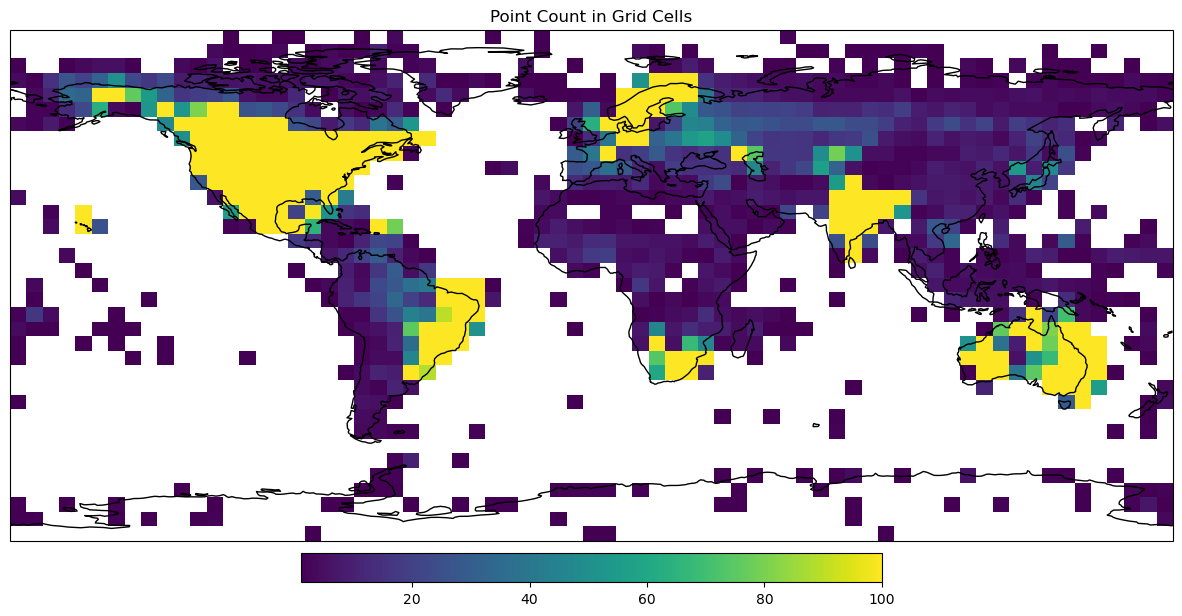

In [4]:
fig, ax = plt.subplots(figsize=(15,8), subplot_kw={'projection': ccrs.PlateCarree()})

cmap = plt.get_cmap('viridis')
cmap.set_under('white')

# use hexbin?
cax = ax.imshow(hist.T, extent=(-180.0, 180.0, -90.0, 90.0), origin='lower', cmap=cmap, aspect='auto', vmin=1, vmax=100)
ax.coastlines()
ax.set_extent((-180.0, 180.0, -90.0, 90.0))

cbar = plt.colorbar(cax, orientation="horizontal", shrink=0.5, pad=0.02)
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
plt.title('Point Count in Grid Cells')

plt.show()

# Chunk sizes

In [5]:
cs = pd.read_csv("chunks.csv.zip")
cs.head()

,offset,length,filter_mask,chunk_offset,type,object,id
0,184665083,4474,b'\x00\x00\x00\x00',"(0,)",chunk,pr,0
1,184669557,4812,b'\x00\x00\x00\x00',"(8192,)",chunk,pr,1
2,184674369,3874,b'\x00\x00\x00\x00',"(16384,)",chunk,pr,2
3,184678243,4273,b'\x00\x00\x00\x00',"(24576,)",chunk,pr,3
4,184682516,5182,b'\x00\x00\x00\x00',"(32768,)",chunk,pr,4


In [6]:
cs[["object", "length"]].groupby("object").count()

,length
object,
pr,137375
snow,137375
snwd,137375
tasmax,137375
tasmin,137375


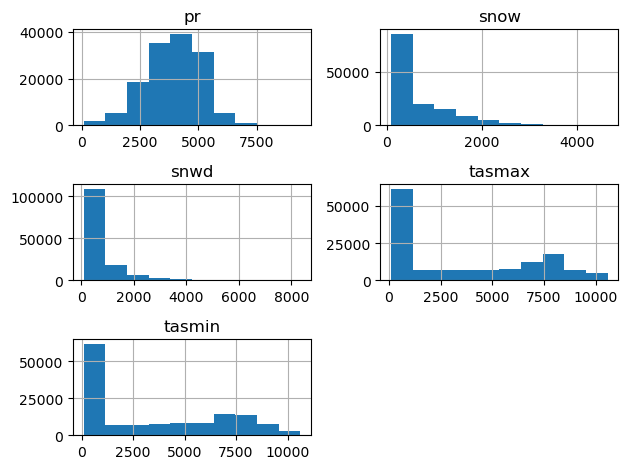

In [7]:
cs[["length", "object"]].pivot(columns="object").loc[:, "length"].hist(legend=False)
plt.tight_layout()
plt.savefig("chunks.svg")

# Plots from "GHCNd treasury"

## Fig. 1

Number of operational weather stations within the GHCN-Daily database recording precipitation data per 5° grid cell in a) 1900, b) 1925, c) 1950, d) 1975, e) 2000 and f) 2017.

In [8]:
counts = {1900: [], 1925: [] , 1950: [], 1975: [], 2000: [], 2017: []}
stations = netCDF4.chartostring(f["station"][...])

year_datenums = {}
for year in counts:
    if (year % 4 == 0 and year % 100 != 0) or (year % 400 == 0):
        ndays = 366  # leap year
    else:
        ndays = 365

    dates = cftime.date2num(
        cftime.num2date(np.arange(ndays), f"days since {year}-01-01", "gregorian"),
        f["time"].getncattr("units"),
        f["time"].getncattr("calendar")
    ).astype(int)
    year_datenums[year] = dates

frm = 0
for i, size in enumerate(f["rowSize"][...]):
    to = frm + size
    pr = f["pr"][frm:to]
    nctime = f["time"][frm:to].astype(int)

    for year in counts:
        year_dates = year_datenums[year]
        mask = np.isin(nctime, year_dates)
        pr_year = pr[mask]

        if pr_year.size:
            counts[year].append(i)

    frm = to  # next station starting point

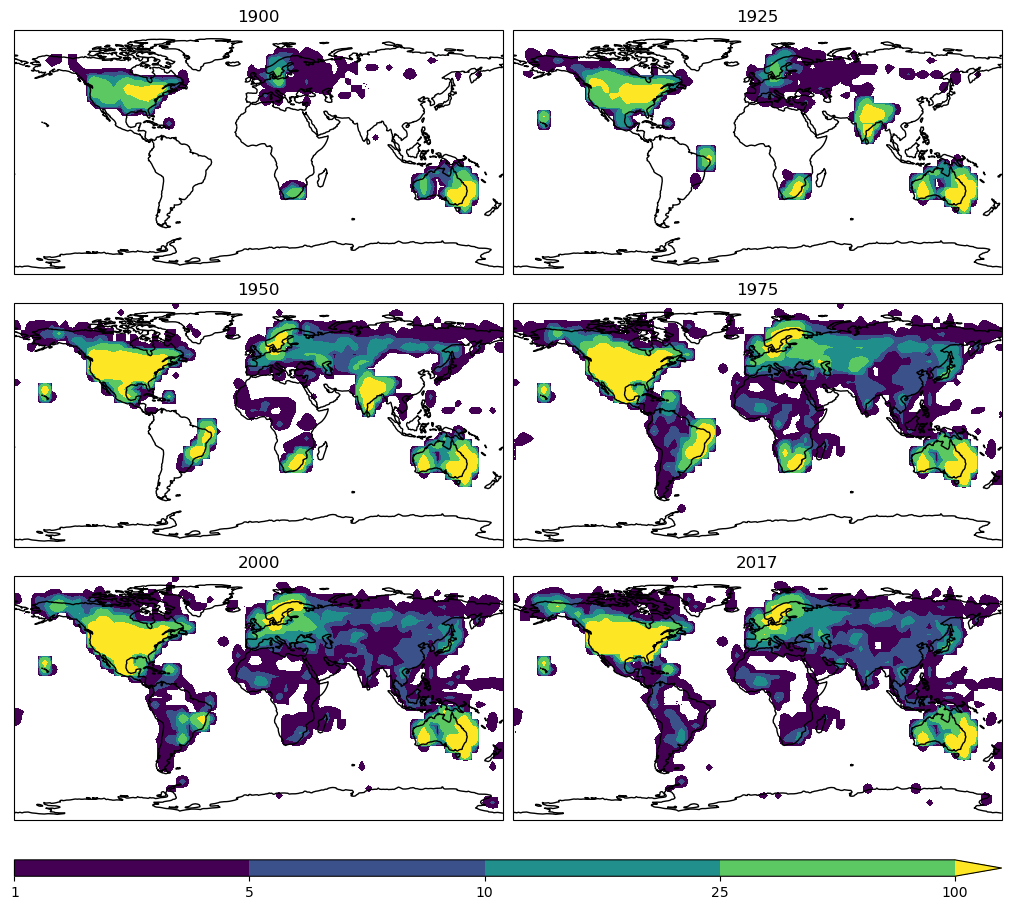

In [9]:
fig, axes = plt.subplots(
    nrows=3,
    ncols=2,
    figsize=(10, 12),
    layout="compressed",
    subplot_kw={'projection': ccrs.PlateCarree()})

# Discrete colorbar
boundaries = [1, 5, 10, 25, 100]
cmap = plt.get_cmap('viridis')
cmap.set_under('white')
norm = mcolors.BoundaryNorm(boundaries, cmap.N, extend='max')

for i, (year, ax) in enumerate(zip(counts.keys(), axes.flat)):
    # Histogram
    x_points = f["lon"][counts[year]]
    y_points = f["lat"][counts[year]]
    x_grid, y_grid = np.meshgrid(np.arange(-180, 180, 5), np.arange(-90, 90, 5))
    # Count the number of points in each cell
    hist, x_edges, y_edges = np.histogram2d(x_points, y_points, bins=[x_grid[0], y_grid[:, 0]])

    # Plot
    im = ax.imshow(hist.T, cmap=cmap, norm=norm, extent=(-180.0, 180.0, -90.0, 90.0), origin="lower", interpolation="bilinear")
    ax.set_title(f'{year}')
    ax.coastlines()
    ax.set_extent((-180.0, 180.0, -90.0, 90.0))

fig.colorbar(ScalarMappable(norm=norm, cmap=cmap), ax=axes, orientation='horizontal', boundaries=boundaries,
             shrink=1, anchor=(0,0), fraction=.05, aspect=60)
plt.savefig("figures/stations_years.svg", bbox_inches="tight")
plt.show()

## Fig. 4

Fig. 4. Total number of weather stations per country or territory contained in the GHCN-Daily database. All sources with at least 100 weather stations are listed.

In [10]:
import urllib.request

country_codes = netCDF4.chartostring(f["station"][:, :2])
countries_url = "https://www.ncei.noaa.gov/pub/data/ghcn/daily/ghcnd-countries.txt"

with urllib.request.urlopen(countries_url) as fin:
    fips_df = pd.DataFrame(
        [line.rstrip("\n").split(" ", 1) for line in fin.read().decode("utf-8").split("\n")],
        columns=["fips", "name"]
    ).dropna().set_index("fips")

codes, counts = np.unique(country_codes, return_counts=True)
counts_df = pd.DataFrame.from_dict({"fips": codes, "counts": counts}).set_index("fips")

df = fips_df.join(counts_df)
df100 = df[df["counts"] > 100].sort_values("counts", ascending=False)
df100 = df100[~df100["name"].str.contains("[", regex=False)]


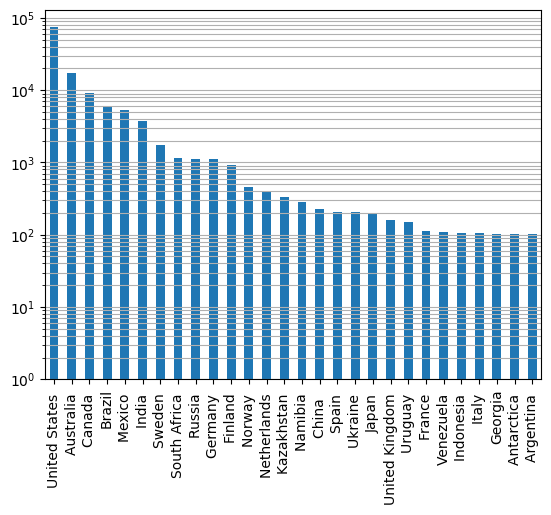

In [11]:
ax = df100.plot.bar(x="name", y="counts", log=True, legend=False, xlabel="")
ax.yaxis.grid(True, which='both', linestyle='-')
plt.savefig("counts.svg")

## Fig. 5

Prevalence of a subset of GHCN-Daily variables (%) in weather station records within the United States and globally.

In [12]:
code = "US"
us_vs_world = pd.concat([
    df.loc[[code]],
    pd.DataFrame(
        data=[("International", "International", df[df.index != code]["counts"].sum())],
        columns=["fips", "name", "counts"]
    ).set_index("fips")
])

In [13]:
us_vs_world  # esto es el numero de estaciones de US contra el mundo

,name,counts
fips,,
US,United States,74243
International,International,53749


In [ ]:
vs = ["tasmin", "tasmax", "pr", "snow", "snwd"]
US_count = [0]*len(vs)
International_count = [0]*len(vs)

stations = netCDF4.chartostring(f["station"][...])
frm = 0
for i, st in enumerate(stations):
    to = frm + f["rowSize"][i]

    for j, v in enumerate(vs):
        data = f[v][frm:to]
        count = (~data.mask).sum()

        if st.startswith(code):
            US_count[j] += count
        else:
            International_count[j] += count

    frm = to

df = pd.DataFrame.from_dict({"variable": vs, "US": US_count, "International": International_count})
total = (df["US"] + df["International"]).sum()
df["US%"] = df["US"] / total
df["International%"] = df["International"] / total

In [ ]:
df

In [ ]:
df.set_index("variable")[["US%", "International%"]].plot.bar(stacked=True)

## Fig.7

GHCN-Daily data availability of a,d) precipitation, b,e) minimum and c,f) maximum temperature. Figures a-c list the number of active weather stations per year. Figures d-f tally the years of activity of individual weather stations based on the number of months with a minimum of twenty observations (min20/month).

# Custom plots

## Histogram of number of days per station

In [ ]:
counts = []
frm = 0
for to in f["rowSize"][...]:
    data = f["pr"][frm:to]
    if isinstance(data.mask, np.bool_) and not data.mask:
        st_obs = data.size
    elif isinstance(data.mask, np.ndarray):
        st_obs = (~data.mask).sum()
    else:
        st_obs = 0

    counts.append(st_obs)
    frm = to

counts = np.array(counts)

In [ ]:
counts[counts < 31].size, counts[counts >= 31].size

In [ ]:
plt.hist(counts, range=(31,counts.max()))

## Station record length

Count the number of observations for each station. Valid values are those who are not masked.

In [5]:
counts = []
frm = 0
for to in f["rowSize"][...]:
    data = f["pr"][frm:to]
    if isinstance(data.mask, bool) and data.mask.any():
        st_obs = (~data.mask).sum()
    else:
        st_obs = data.size
    counts.append(st_obs)
    frm = to

Create the color for each station (blue: more than 100 years, red: 50-99 years, white: less than 50 years).

In [6]:
colors = []
for count in counts:
    if count < 365*50:
        colors.append("white")
    elif count >= 365*50 and count < 365*99:
        colors.append("red")
    else:
        colors.append("blue")

Plot the stations.

In [ ]:
fig = plt.figure(figsize=(25, 20))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()

lats = list(f["lat"][...])
lons = list(f["lon"][...])

for lat, lon, color in zip(lats, lons, colors):
    ax.plot(lon, lat, marker='o', color=color, markersize=7.5, transform=ccrs.PlateCarree(), markeredgecolor='black', markeredgewidth=.5)

## Particular station data

In [ ]:
stations = f["station"][...].view('S11').ravel().tolist()

st = b"AR000087007"
i = stations.index(st)

frm = f["rowSize"][0:i].sum()
to = f["rowSize"][0:i+1].sum()

plt.hist(f["tasmax"][frm:to])

## Pandas

In [ ]:
df = pd.DataFrame({
    "station": [st.decode("ascii") for st in stations for _ in range(f["rowSize"][stations.index(st)])],
    "time": list(f["time"][...]),
    "tasmax": f["tasmax"][...].filled(np.nan) * f["tasmax"].getncattr("scale_factor"),
    "tasmin": f["tasmin"][...].filled(np.nan) * f["tasmin"].getncattr("scale_factor"),
})

In [ ]:
df

In [ ]:
df.groupby("station").max()

In [ ]:
df[df["station"] == "ASN00002064"][["tasmax", "tasmin"]].plot()

## xarray

In [ ]:
df = pd.DataFrame({
    "station": [st.decode("ascii") for st in stations for _ in range(f["rowSize"][stations.index(st)])],
    "time": cftime.num2pydate(f["time"][...].data, f["time"].getncattr("units"), f["time"].getncattr("calendar")),
    "tasmax": f["tasmax"][...].filled(np.nan) * f["tasmax"].getncattr("scale_factor"),
    "tasmin": f["tasmin"][...].filled(np.nan) * f["tasmin"].getncattr("scale_factor"),
})

In [ ]:
ds = xarray.Dataset.from_dataframe(df.set_index(["station", "time"]))
ds

In [ ]:
ds["tasmax"].sel(station=["AGM00060559", "AR000087007"], time=slice("19500101", None)).resample(time="YE").mean().plot.line(x="time")